# Loading Data and Library

In [135]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, classification_report

import pickle
import imblearn
from imblearn.over_sampling import SMOTE


# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [45]:
df = pd.read_csv('scaled_feature_engineered_data_stroke.csv')
df.drop(df.columns[0],axis=1,inplace=True)
df.head(3)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,gender_Male,gender_Other,ever_married_Yes,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,bmi_age_product,hypertension_and_heart_disease
0,1.051434,0.0,1.0,2.320494,1.022550,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.218743,0
1,0.786070,0.0,0.0,1.980500,0.483059,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.829762,0
2,1.626390,0.0,1.0,0.194001,0.571664,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.697981,0


# Feature Selection 

In [46]:
selector = SelectKBest(score_func=f_classif)
fits = selector.fit(df.drop("stroke",axis=1),df["stroke"])

x=pd.DataFrame(fits.scores_)
columns = pd.DataFrame(df.drop('stroke',axis=1).columns)

fscores = pd.concat([columns,x],axis=1)
fscores.columns = ['Attribute','Score']
fscores.sort_values(by='Score',ascending=False)

,Attribute,Score
0,age,326.916568
16,bmi_age_product,313.480396
2,heart_disease,94.698406
1,hypertension,84.953542
3,avg_glucose_level,70.921148
11,ever_married_Yes,60.667230
8,work_type_children,36.184470
17,hypertension_and_heart_disease,33.536698
13,smoking_status_formerly smoked,21.376277
7,work_type_Self-employed,19.818466


In [55]:
col = list(fscores["Attribute"])

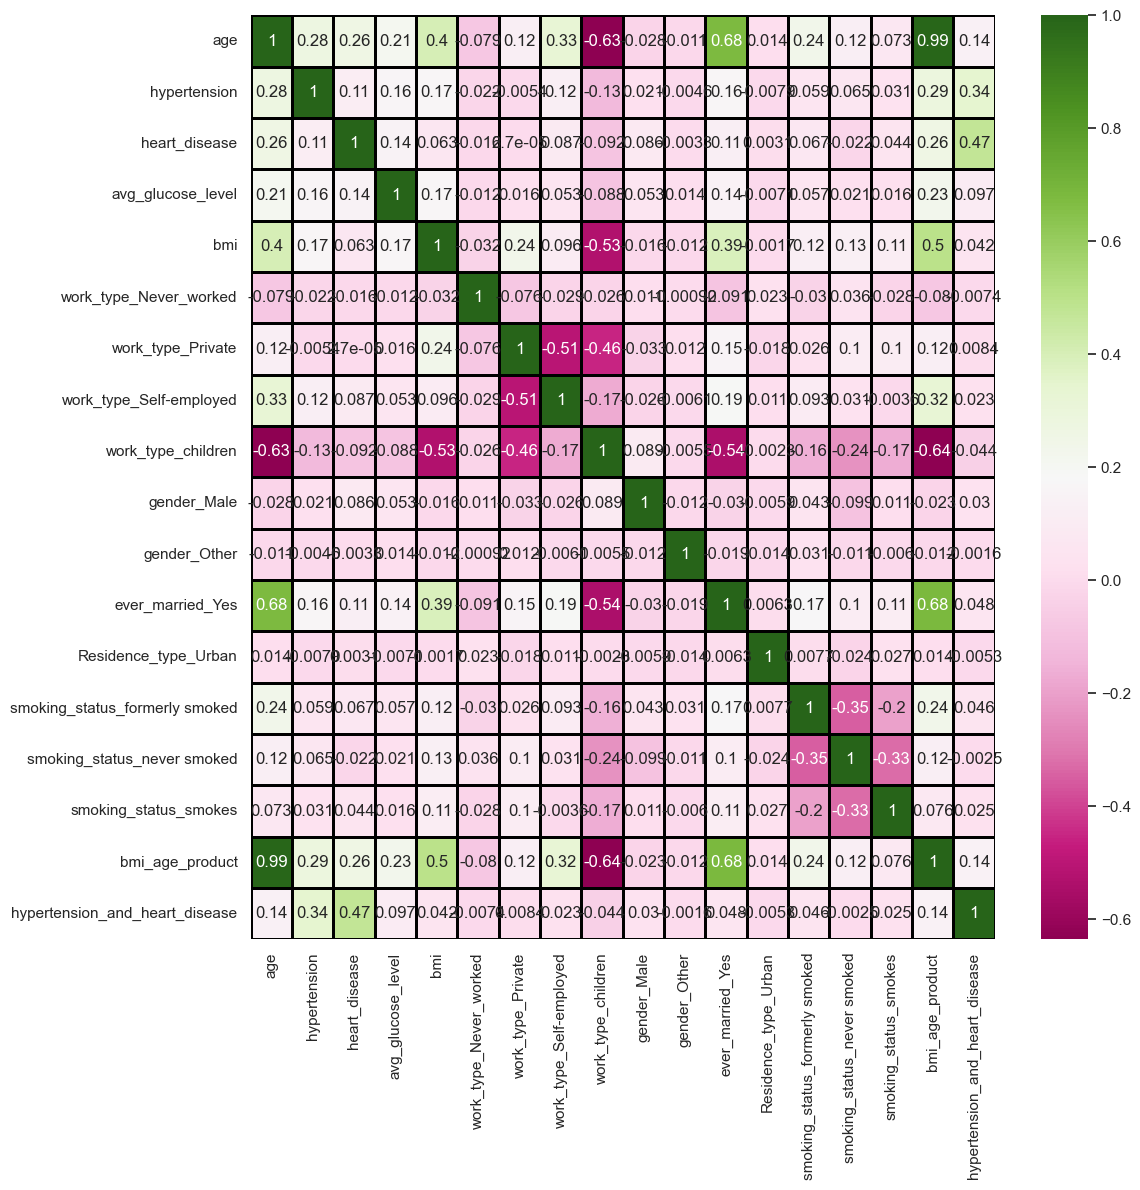

In [48]:
sns.heatmap(df[col].corr(),cmap="PiYG",linecolor="black",linewidth=1, annot=True)
sns.set(rc={'figure.figsize':(12,12)})

### From the above correlation Matrix we can easily notice age highly correlates with the `Age`  therefore we can remove age all the other attributes aren't that higly correlated and hence can be considered for further

In [56]:
col.remove("age")
target = df["stroke"]
final_df = df[col]

# Handeling Imbalance in the data 

> In the EDA part I noticed high imbalnce in the Target variable where there were around for 4861 `False` - 0 and only 249 records for `True` -1 

> This Condition can be handeled using few methods example :-
* Stratified sampling :  as the data for True is very less we can't use this beacuse we will have very little data to compute
* SMOTE : We can increase the minority class exmaples by replicating them
* Cluster Sampling : We can distribute the data through simple clusters and pick one sample to impute


**`I am using smote beacuse i have very little data smote will increase the sample size of the True data and hence data will be balanced at some extend`**

In [57]:
smote = SMOTE()
final_df,target = smote.fit_resample(final_df,target)

In [59]:
final_df.shape

(9722, 17)

### Train Test and Val split

In [63]:
# Train and test split in the ratio of 80 - 20
X_train, X_test, y_train, y_test = train_test_split(final_df, target,test_size=0.2, shuffle = True, random_state = 8)

#Train was again split to make Train and Val in ratio of 75-25
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.25,random_state=8)

# Now the Split is 60 - 20 -20

## Experiment 1 (Logistic Regressoion)

In [77]:

search_space = np.logspace(-5, 8, 15)
param_grid = {'C': search_space}

LogisticReg = LogisticRegression()
LogisticReg.fit(X_train,y_train)

preds = LogisticReg.predict(X_test)
metrics.f1_score(y_test,preds)

0.7884427032321254

In [80]:
lr_cv = GridSearchCV(LogisticReg, param_grid, cv = 5)
lr_cv.fit(X_train,y_train)
print("After Tuning {}".format(lr_cv.best_params_)) 
print("Scores on Best params{}".format(lr_cv.best_score_))

After Tuning {'C': 0.05179474679231213}
Scores on Best params0.7863516574289238


In [82]:
C = lr_cv.best_params_['C']
refinedlogreg = LogisticRegression(C=C)
refinedlogreg.fit(X_train,y_train)

LogisticRegression(C=0.05179474679231213)

In [83]:
log_reg = refinedlogreg.predict(X_test)
metrics.f1_score(y_test,log_reg)

0.7908560311284046

<Axes: >

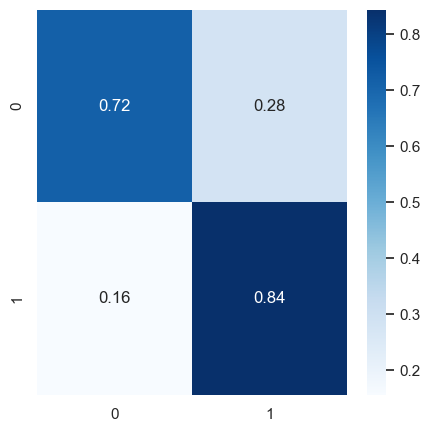

In [95]:
con_matrix = metrics.confusion_matrix(y_test, log_reg)
row_sums = con_matrix.sum(axis=1, keepdims=True)
normalized_confusion_matrix = con_matrix / row_sums
plt.figure(figsize=(5, 5))
sns.heatmap(normalized_confusion_matrix, annot=True, cmap='Blues', fmt='.2f')

**Validation**

<Axes: >

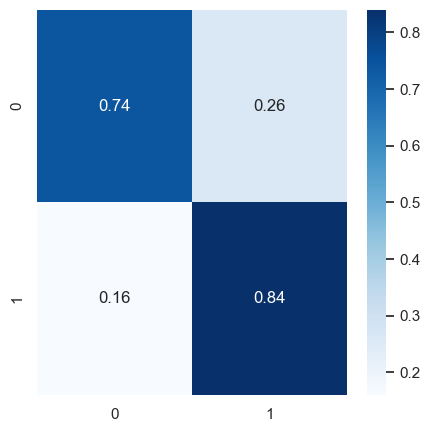

In [122]:
val_preds = refinedlogreg.predict(X_val)
val_con_matrix = metrics.confusion_matrix(y_val, val_preds)

row_sums = val_con_matrix.sum(axis=1, keepdims=True)
normalized_confusion_matrix = val_con_matrix / row_sums
plt.figure(figsize=(5, 5))
sns.heatmap(normalized_confusion_matrix, annot=True, cmap='Blues', fmt='.2f')

In [123]:
report = classification_report(y_val, val_preds)
print(report)

              precision    recall  f1-score   support

         0.0       0.82      0.74      0.78       967
         1.0       0.77      0.84      0.80       978

    accuracy                           0.79      1945
   macro avg       0.79      0.79      0.79      1945
weighted avg       0.79      0.79      0.79      1945



**NOTE: 
Here The F1 Score is 79% which seems good but as of we have LogisticRegression classifier Rank certain categories more and creats a baise when those categories are value high we can see in the `validation set` it has performed very well for True we need to improve it for False as well therefore I need to Run more Experiments** 



## Experiment 2 : With RandomForest Classifier


* **RF is a ensembling method which creates multiple decision trees by using random subsets of features on bootstrap samples of the dataset. Each decision tree makes predictions independently.**

* **It Overcomes the probelm we faced in Logistic regression**

In [99]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

predictions = rf.predict(X_test)
metrics.f1_score(y_test,predictions)


0.9593830334190231

In [109]:
train_results = []
test_results = []
n_estimators = [1,2,4,8,16,32,64,128]
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator,random_state=42,criterion="entropy")
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    

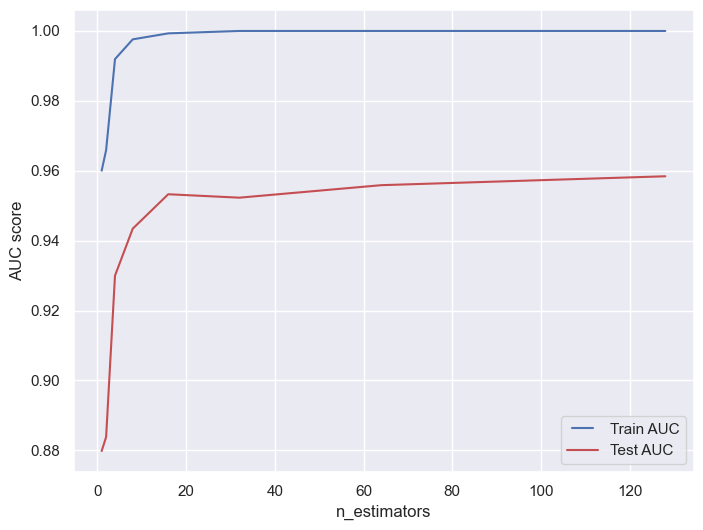

In [116]:
plt.figure(figsize=(8, 6))

line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

In [114]:
estimator = 16
randomf = RandomForestClassifier()
randomf.fit(X_train,y_train)

RandomForestClassifier()

<Axes: >

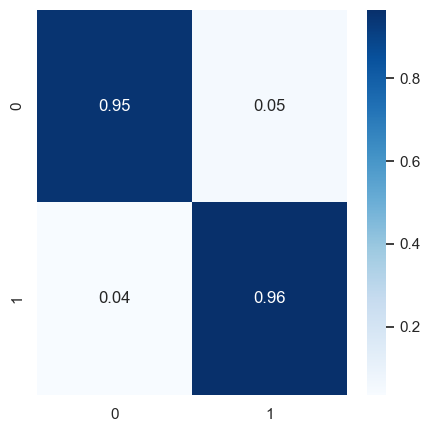

In [124]:
rf_preds = randomf.predict(X_test)

val_con_matrix = metrics.confusion_matrix(y_test, rf_preds)

row_sums = val_con_matrix.sum(axis=1, keepdims=True)
normalized_confusion_matrix = val_con_matrix / row_sums
plt.figure(figsize=(5, 5))
sns.heatmap(normalized_confusion_matrix, annot=True, cmap='Blues', fmt='.2f')

In [125]:
report = classification_report(y_test, rf_preds)
print(report)

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96       981
         1.0       0.95      0.96      0.96       964

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945



**Woowwwwww.... this Overfittingggggg💔🙂**

## Validation Step

<Axes: >

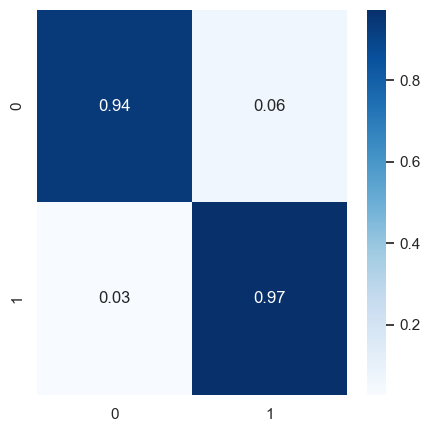

In [118]:
rf_preds = randomf.predict(X_val)

val_con_matrix = metrics.confusion_matrix(y_val, rf_preds)

row_sums = val_con_matrix.sum(axis=1, keepdims=True)
normalized_confusion_matrix = val_con_matrix / row_sums
plt.figure(figsize=(5, 5))
sns.heatmap(normalized_confusion_matrix, annot=True, cmap='Blues', fmt='.2f')

In [121]:
report = classification_report(y_val, rf_preds)
print(report)

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       967
         1.0       0.94      0.97      0.96       978

    accuracy                           0.95      1945
   macro avg       0.95      0.95      0.95      1945
weighted avg       0.95      0.95      0.95      1945



In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 6)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 4)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = randomf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train,y_train)
rf_random.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [133]:
re_trained_rf_model = RandomForestClassifier(bootstrap=False, n_estimators=1280)
re_trained_rf_model.fit(X_train,y_train)
retrained_preds = re_trained_rf_model.predict(X_test)

report = classification_report(y_test, retrained_preds)
print(report)

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       981
         1.0       0.96      0.96      0.96       964

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945



### The Precision and recall values are too high but this is beacuse the data set is a Toy dataset I have run various Validation to check the correctness of the model the high score of the model are due to SMOTE we used it fabricated similar data hence model has learned too Good for `True Strokes` 

# Dumping the Model

In [137]:
pickle.dump(re_trained_rf_model, open('myClassifier.pkl', 'wb'))
picklemodel = pickle.load(open('myClassifier.pkl', 'rb'))

y_pred_val = picklemodel.predict(X_val)
X_val['y_pred_test'] = y_pred_val.tolist()
X_val.to_csv('Predicted_model_csv.csv')